In [1]:
import sys, os
sys.path.insert(0, '..')

In [2]:
import graph_tool.all as gt
import graph_embeddings
from models.crosswalk import Crosswalk
from utils.score import statistical_parity
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-08-11 01:19:03.030823: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-11 01:19:03.055755: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2022-08-11 01:19:03.056838: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e849881650 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-11 01:19:03.056852: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-11 01:19:03

In [3]:

DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

models = {}
window_length = 5
num_walks = 10
dim = 128

models["baseline"] = graph_embeddings.DeepWalk(window_length=window_length, num_walks=num_walks, restart_prob=0)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80
)

models["group-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

models["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks)
models["fairwalk-group"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
)
models['GCN'] = graph_embeddings.GCN()
models["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2)
models["graphsage"] = graph_embeddings.GraphSage()
models["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2)
models["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256])
models["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2)

models['crosswalk'] = Crosswalk(group_membership=group_ids, window_length=window_length, num_walks=num_walks)

In [4]:
A[0:].todense(), A.shape

(matrix([[0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.]]),
 (105, 105))

In [5]:
embs = {}

for k, model in tqdm(models.items()):
    print(model.__class__.__name__)
#     sys.stdout = open(os.devnull, 'w')
    
    if "unbiased" in k:
        from residual2vec.word2vec import Word2Vec
        m = Word2Vec(vocab_size=A.shape[0] + 1, embedding_size=dim, padding_idx=A.shape[0])
        emb = model.fit(A).transform(m)
    else:    
        emb = model.fit(A).transform(dim=dim)
#     sys.stdout = sys.__stdout__
    embs[k] = emb

  8%|██████████▏                                                                                                               | 1/12 [00:00<00:01,  7.73it/s]

DeepWalk
residual2vec_sgd



  0%|                                                                                                                       | 0/329 [00:00<?, ?it/s, loss=1.2]


  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.19]


 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 313.69it/s, loss=1.15]


 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 313.69it/s, loss=1.08]


 61%|█████████████████████████████████████████████████████████████████                                          | 200/329 [00:00<00:00, 348.66it/s, loss=1.04]


 61%|█████████████████████████████████████████████████████████████████                                          | 200/329 [00:00<00:00, 348.66it/s, loss=1.02]


 17%|████████████████████▎                                                                                                     | 2/12 [00:04<00:28,  2.82s/it]

residual2vec_sgd



  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.36]


  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.23]


 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 328.36it/s, loss=1.27]


 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 328.36it/s, loss=1.24]


 61%|█████████████████████████████████████████████████████████████████▋                                          | 200/329 [00:00<00:00, 355.32it/s, loss=1.2]


 61%|█████████████████████████████████████████████████████████████████                                          | 200/329 [00:00<00:00, 355.32it/s, loss=1.26]


 25%|██████████████████████████████▌                                                                                           | 3/12 [00:05<00:18,  2.01s/it]

Fairwalk


 33%|████████████████████████████████████████▋                                                                                 | 4/12 [00:06<00:10,  1.30s/it]

Fairwalk


 42%|██████████████████████████████████████████████████▊                                                                       | 5/12 [00:06<00:06,  1.10it/s]

GCN
Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAP

1/1 [==============================] - 0s 62ms/step - loss: 0.0069 - val_loss: 0.0117
Epoch 51/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0072 - val_loss: 0.0117
Epoch 52/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0072 - val_loss: 0.0115
Epoch 53/200
1/1 [==============================] - 0s 60ms/step - loss: 0.0069 - val_loss: 0.0114
Epoch 54/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 55/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0070 - val_loss: 0.0113
Epoch 56/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 57/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0069 - val_loss: 0.0112
Epoch 58/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0068 - val_loss: 0.0113
Epoch 59/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0069 - val_loss: 0.0114
Epoch 60/200
1/1 [=====

 50%|█████████████████████████████████████████████████████████████                                                             | 6/12 [00:13<00:18,  3.08s/it]

GCN
Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAP

Epoch 51/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0066 - val_loss: 0.0118
Epoch 52/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0067 - val_loss: 0.0118
Epoch 53/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0066 - val_loss: 0.0119
Epoch 54/200
1/1 [==============================] - 0s 51ms/step - loss: 0.0067 - val_loss: 0.0120
Epoch 55/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0066 - val_loss: 0.0121
Epoch 56/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0068 - val_loss: 0.0121
Epoch 57/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0067 - val_loss: 0.0122
Epoch 58/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0064 - val_loss: 0.0124
Epoch 59/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0063 - val_loss: 0.0125
Epoch 60/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0063 - val_loss: 0.0128
Epoch 61/2

 58%|███████████████████████████████████████████████████████████████████████▏                                                  | 7/12 [00:21<00:23,  4.62s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-11 01:19:27.041291: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 651ms/step - loss: 0.7022 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-11 01:19:27.709815: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 565ms/step - loss: 0.6783 - binary_accuracy: 0.5286
Epoch 4/5


2022-08-11 01:19:28.379570: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 700ms/step - loss: 0.6515 - binary_accuracy: 0.6286
Epoch 5/5


2022-08-11 01:19:29.079747: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 771ms/step - loss: 0.6327 - binary_accuracy: 0.6619


2022-08-11 01:19:29.750111: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 184ms/step


2022-08-11 01:19:30.315981: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 8/12 [00:26<00:19,  4.82s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-11 01:19:32.236388: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 542ms/step - loss: 0.7082 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-11 01:19:32.909371: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 662ms/step - loss: 0.6881 - binary_accuracy: 0.5095
Epoch 4/5


2022-08-11 01:19:33.592032: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 804ms/step - loss: 0.6588 - binary_accuracy: 0.5619
Epoch 5/5


2022-08-11 01:19:34.261190: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 624ms/step - loss: 0.6469 - binary_accuracy: 0.6381


2022-08-11 01:19:34.973129: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 268ms/step


2022-08-11 01:19:35.542598: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 9/12 [00:31<00:14,  4.95s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Epoch 50/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 51/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 52/200
1/1 [==============================] - 0s 100ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 53/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 54/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 55/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 56/200
1/1 [==============================] - 0s 99ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 57/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 58/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 59/200
1/1 [==============================] - 0s 54ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 60/

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 10/12 [00:42<00:13,  6.84s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Epoch 50/200
1/1 [==============================] - 0s 116ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 51/200
1/1 [==============================] - 0s 131ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 52/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 53/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 54/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 55/200
1/1 [==============================] - 0s 99ms/step - loss: 0.0086 - val_loss: 0.0100
Epoch 56/200
1/1 [==============================] - 0s 92ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 57/200
1/1 [==============================] - 0s 96ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 58/200
1/1 [==============================] - 0s 91ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 59/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0085 - val_loss: 0.0100
Epoch 6

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 11/12 [00:57<00:09,  9.06s/it]

Crosswalk


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:59<00:00,  4.99s/it]


In [6]:

def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)



In [7]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [8]:
scores = {}
for k, graph in rgraphs.items():
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

class score:  baseline 0.18350637969381656
class score:  degree-unbiased 0.16521661092407866
class score:  group-unbiased 0.09946197228769423
class score:  fairwalk 0.14611477419158628
class score:  fairwalk-group 0.15413466652344265
class score:  GCN 0.1749531430181661
class score:  gcn-doubleK 0.15307040457197071
class score:  graphsage 0.11287101092527081
class score:  graphsage-doubleK 0.08316304422887198
class score:  gat 0.17252836971977867
class score:  gat-doubleK 0.15063600711097294
class score:  crosswalk 0.08914961058135262


[Text(0,0,'baseline'),
 Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK'),
 Text(0,0,'crosswalk')]

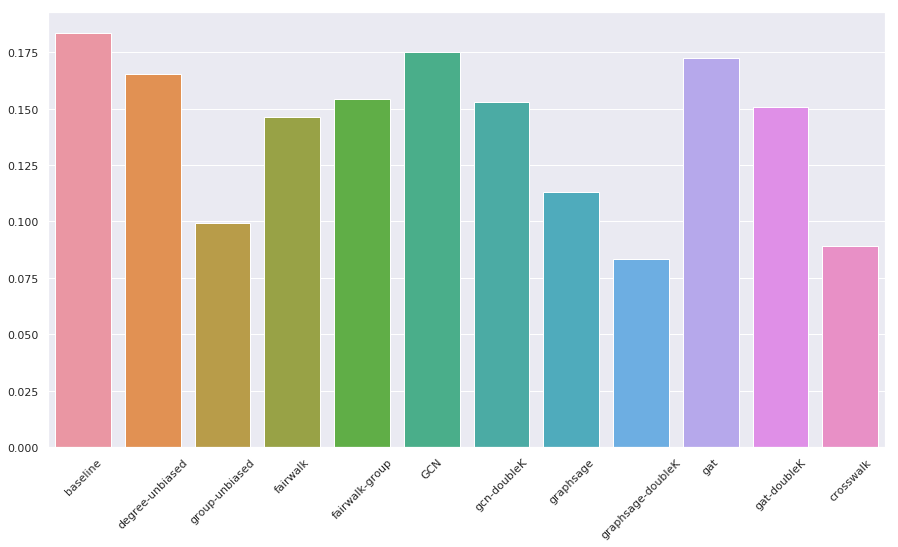

In [9]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [10]:
import pickle as pkl
pkl.dump(rgraphs, open('/tmp/rgraphs.pkl', 'wb'))
pkl.dump(group_ids, open('/tmp/group_ids.pkl', 'wb'))
pkl.dump(embs, open('/tmp/embs.pkl', 'wb'))


In [11]:
# check shapes of different properties of the r2v
model = models['degree-unbiased']

In [12]:
type(model)

residual2vec.residual2vec_sgd.residual2vec_sgd

In [13]:
model.in_vec.shape, model.out_vec.shape

((105, 128), (105, 128))